In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

from src.linear import Linear
from src.loss import MSELoss
from src.activation_functions import TanH, Sigmoid
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np

*First, let's test out a basic linear model*

In [2]:
# params for data 
# 1000 samples, each containing 3 features (input_dim)
# the output 'y' will be 1000 samples with 2 (output_dim) 
samples = 1000 
input_dim = 3
output_dim = 2

# generate data (set seed too for reproductibility)
# data -> (1000,3)
np.random.seed(0)
data = np.random.randn(samples, input_dim)

# generate weights and biases
# these are the target weights and biases that we are trying to recreate in the linear model
# they are the ground truth variables
weights = np.random.randn(input_dim, output_dim)
bias = np.random.randn(output_dim)

# calculation of the output
# y -> (1000,2)
y = data @ weights + bias

In [3]:
# init of the model and loss module
model = Linear(input_dim=input_dim, output_dim=output_dim)
loss_function = MSELoss()

Epoch 0: loss=7.297367400655688
Epoch 20: loss=3.400395553400089
Epoch 40: loss=1.5890023611500879
Epoch 60: loss=0.7445771560652542
Epoch 80: loss=0.3498155723365985
Epoch 100: loss=0.16476459831315843
Epoch 120: loss=0.07779161319906121
Epoch 140: loss=0.03681230772189562
Epoch 160: loss=0.017457869594697903
Epoch 180: loss=0.00829609782232709
Epoch 200: loss=0.003949916569141717
Epoch 220: loss=0.001884002579410072
Epoch 240: loss=0.000900127705033453
Epoch 260: loss=0.00043073206718314416
Epoch 280: loss=0.00020641639142772762


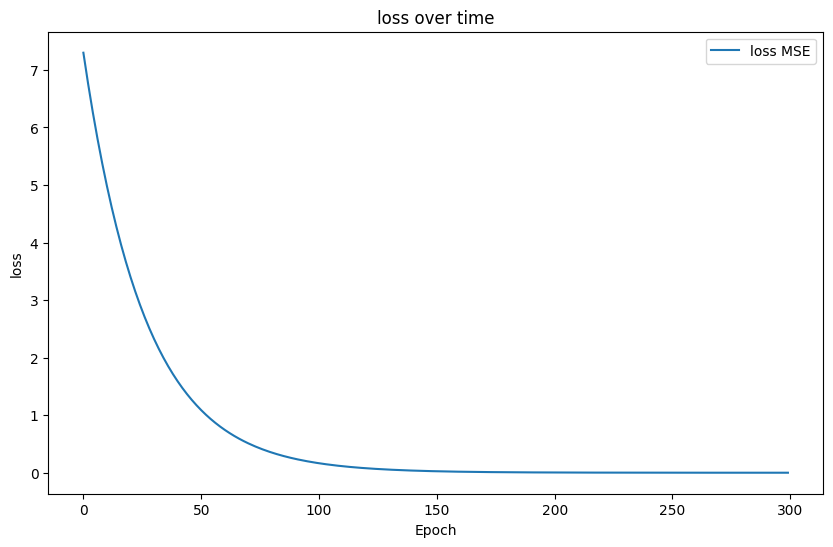

In [4]:
learning_r = 0.01 # the larger the learning rate 
max_epoch = 300
log_loss = []

for epoch in range(max_epoch):
    # forward pass in the model to get predictions
    yhat = model.forward(data)

    # calculate the loss using MSE
    loss = loss_function.forward(y, yhat)

    # backpropagate the MSE loss in the network
    loss_gradient = loss_function.backward(y, yhat)

    # update the weight gradients before updating 
    model.backward_update_gradient(data, loss_gradient)

    # update the weights and biases
    model.update_parameters(learning_rate=learning_r)

    # save the loss to monitor later
    log_loss.append(loss.mean())

    if epoch % 20 == 0:
        print(f'Epoch {epoch}: loss={loss.mean()}')

# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(log_loss, label='loss MSE')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('loss over time')
plt.legend()
plt.show()

*Now let's test the activation functions*

X shape: (2000, 2), which should verify (2 x n_samples, 2), and n_samples=1000 :)
y shape: (2000,), should just be a single row of 2 x n_samples elements!


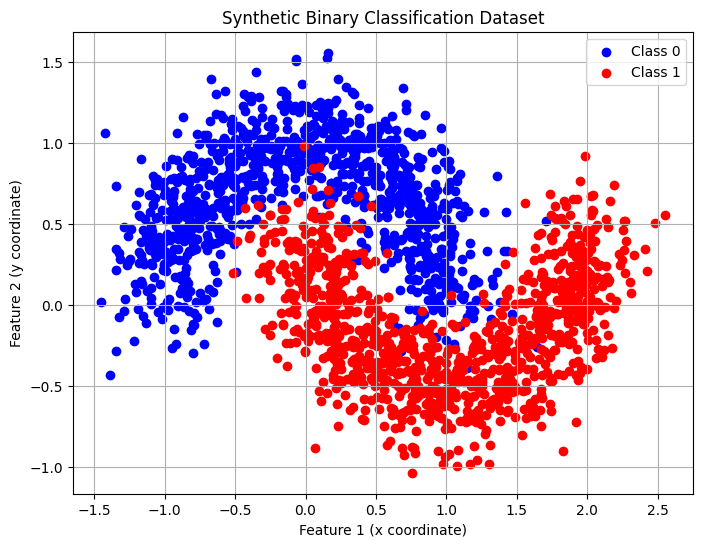

In [5]:
# we want a dataset of points with labels of 0 or 1
# the idea here is to create a non linearly seperable dataset
# let's create moon shaped clusters!
n_samples = 1000
noise=0.2
theta = np.linspace(0, np.pi, n_samples) # n samples of where 0 <= sample point <= π -> this creates dots in a semi circle !

# Class 0: Upper moon
x0 = np.cos(theta) + np.random.normal(0, noise, n_samples) # take cosine of theta for x coordinates, and add noise for a nicer distribution
y0 = np.sin(theta) + np.random.normal(0, noise, n_samples) # same but take the sine for the y coordinates (+ noise)
labels0 = np.zeros(n_samples) # create n sample 'zero labels'

# Class 1: Lower moon (shifted and rotated)
x1 = 1 - np.cos(theta) + np.random.normal(0, noise, n_samples) # same logic as before but shifts to the right by 1 unit
y1 = -np.sin(theta) + 0.5 + np.random.normal(0, noise, n_samples) # taking -sin(theta) flips the moon, we add the 0.5 to shift it downward and add noise
labels1 = np.ones(n_samples) # create n sample 'one labels'

# Combine data
# for X, first n_samples belong to class 0, rest 1
X = np.vstack([np.column_stack((x0, y0)), np.column_stack((x1, y1))]) # create the dataset by combining the 0 and 1 class
print(f'X shape: {X.shape}, which should verify (2 x n_samples, 2), and n_samples={n_samples} :)')
y = np.concatenate([labels0, labels1])
print(f'y shape: {y.shape}, should just be a single row of 2 x n_samples elements!')

plt.figure(figsize=(8, 6))
plt.scatter(X[y==0, 0], X[y==0, 1], c='blue', label='Class 0')
plt.scatter(X[y==1, 0], X[y==1, 1], c='red', label='Class 1')
plt.title("Synthetic Binary Classification Dataset")
plt.xlabel("Feature 1 (x coordinate)")
plt.ylabel("Feature 2 (y coordinate)")
plt.legend()
plt.grid(True)
plt.show()

sample of the new order of indices: [1646  724  747 1425  866 1507  991 1377 1612  902]
Train features: (1600, 2), Train labels: (1600, 1)
Test features: (400, 2), Test labels: (400, 1)


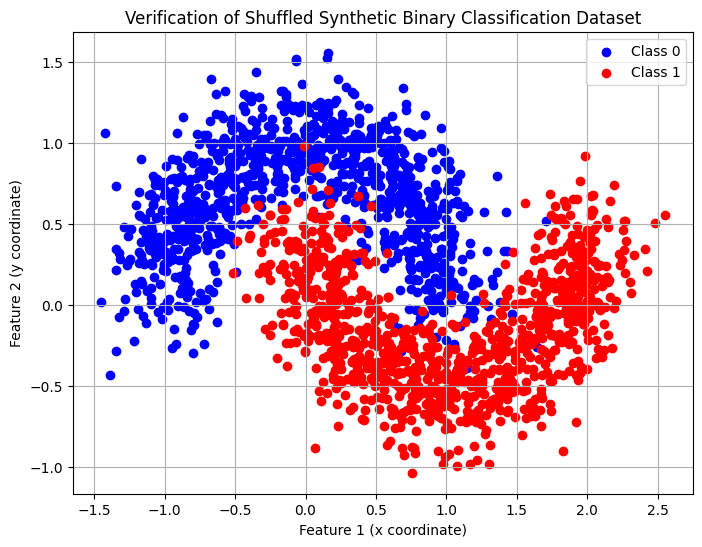

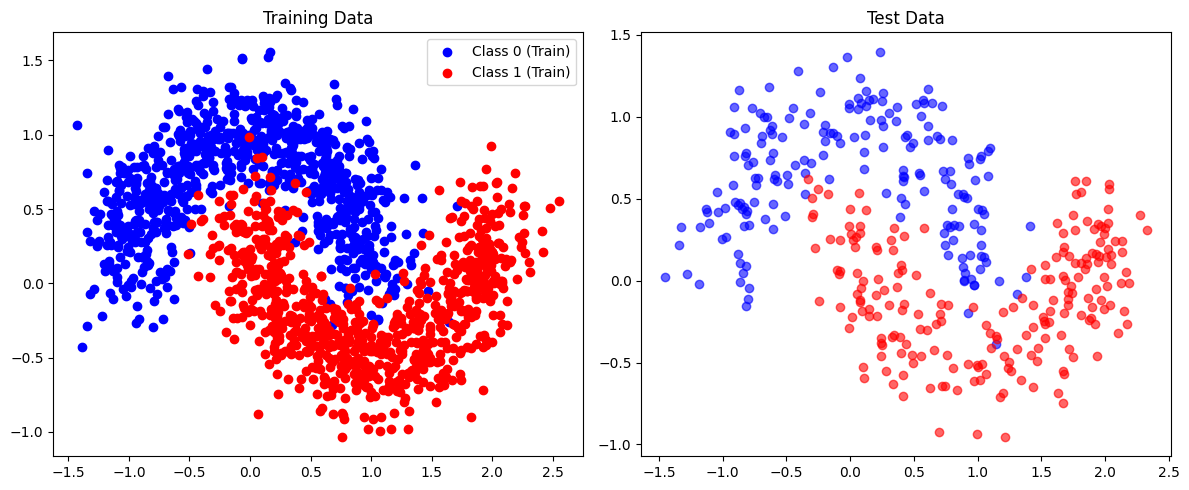

In [6]:
# Before the training loop, let's prepare the data by creating a train/test split (about 80%/20% split)
indices = np.random.permutation(len(X)) # random permutation of indices from 0 to len(X)-1
print(f'sample of the new order of indices: {indices[:10]}')

# shuffle X and y using the same permutation to avoid mixing their labels
# random permutation, but same for both arrays!
# ex: the index 0 is now randomly (for this example) at index 156 for both arrays
X_shuffled = X[indices]
y_shuffled = y[indices]

split_ratio = 0.8 # we want 80% of train
# calculate the index of where the split should happen
# for example with n sample = 2000, 2000 * 0.8 = 1600
split_index = int(len(X_shuffled) * split_ratio) 

# Split the data
X_train, X_test = X_shuffled[:split_index], X_shuffled[split_index:] # splice the X_shuffled array into two new arrays, split at index 'split_index'
y_train, y_test = y_shuffled[:split_index], y_shuffled[split_index:] # same for y_shuffled

#add extra column for matrix sizes to be compatible with rest of the code, so (1600,) -> (1600,1)
y_train = y_shuffled[:split_index].reshape(-1, 1)  
y_test = y_shuffled[split_index:].reshape(-1, 1)

# Verify shapes
print(f"Train features: {X_train.shape}, Train labels: {y_train.shape}")
print(f"Test features: {X_test.shape}, Test labels: {y_test.shape}")

# Let's verify that the data still looks the same and we didnt mix up any indices!
# Plot the full shuffled dataset (original y_shuffled is still 1D)
plt.figure(figsize=(8, 6))
plt.scatter(X_shuffled[y_shuffled==0, 0], X_shuffled[y_shuffled==0, 1], c='blue', label='Class 0')
plt.scatter(X_shuffled[y_shuffled==1, 0], X_shuffled[y_shuffled==1, 1], c='red', label='Class 1')
plt.title("Verification of Shuffled Synthetic Binary Classification Dataset")
plt.xlabel("Feature 1 (x coordinate)")
plt.ylabel("Feature 2 (y coordinate)")
plt.legend()
plt.grid(True)
plt.show()

# Plot training and test data with reshaped labels
plt.figure(figsize=(12, 5))

# Training data (flatten y_train to 1D for indexing)
plt.subplot(1, 2, 1)
plt.scatter(X_train[y_train.ravel()==0, 0], X_train[y_train.ravel()==0, 1], c='blue', label='Class 0 (Train)')
plt.scatter(X_train[y_train.ravel()==1, 0], X_train[y_train.ravel()==1, 1], c='red', label='Class 1 (Train)')
plt.title("Training Data")
plt.legend()

# Test data (flatten y_test to 1D for indexing)
plt.subplot(1, 2, 2)
plt.scatter(X_test[y_test.ravel()==0, 0], X_test[y_test.ravel()==0, 1], c='blue', marker='o', alpha=0.6, label='Class 0 (Test)')
plt.scatter(X_test[y_test.ravel()==1, 0], X_test[y_test.ravel()==1, 1], c='red', marker='o', alpha=0.6, label='Class 1 (Test)')
plt.title("Test Data")

plt.tight_layout()
plt.show()

In [7]:
# parameters
input_dim = 2 # input of 2 because we have 2 coordinates for each point
output_dim = 1 # 1 because we predict one class, 1 or 0
learning_r = 0.009 # play around with that, but a value around 0.01 is pretty good
num_epoch = 2000 # could even lower that a bit based on results but i gets executed very fast anyways

# creating the architecture, relatively straight forward
# input -> linear -> tanh -> linear -> sigmoid -> prediction
# this gives us 2 layers and two activation functions
layer1 = Linear(input_dim, 6) 
activation_fun_1 = TanH()
layer2 = Linear(6, output_dim)
activation_fun_2 = Sigmoid()
loss_fun = MSELoss()

# for plotting later
log_loss = []

for epoch in range(num_epoch):
    # ===================================================================
    # Forward Pass: Compute predictions from input to output
    # ===================================================================
    # Step 1: Input data flows through Layer 1 (Linear transformation: X @ W1 + b1)
    x1 = layer1.forward(X=X_train) # Shape: (batch_size, 6)

    # Step 2: Apply TanH activation to Layer 1's output (non-linear transformation)
    a1 = activation_fun_1.forward(X=x1)  # Shape: (batch_size, 6)

    # Step 3: Pass TanH output to Layer 2 (Linear transformation: a1 @ W2 + b2)
    x2 = layer2.forward(X=a1)  # Shape: (batch_size, output_dim=1)

    # Step 4: Apply Sigmoid to Layer 2's output (squash to [0,1] for binary classification)
    y_pred = activation_fun_2.forward(X=x2)  # Shape: (batch_size, 1)

    # ===================================================================
    # Loss Calculation: Measure prediction error
    # ===================================================================
    # Compute MSE loss between predictions (y_pred) and ground truth (y_train)
    loss = loss_function.forward(y=y_train, yhat=y_pred)  # Scalar value
    log_loss.append(loss)  # Track loss over epochs for visualization

    # ===================================================================
    # Backward Pass: Compute gradients via chain rule (backpropagation)
    # ===================================================================
    # Step 1: Compute initial gradient of loss w.r.t. predictions (dL/dy_pred)
    delta = loss_fun.backward(y=y_train, yhat=y_pred)  # Shape: (batch_size, 1)

    # Step 2: Backprop through Sigmoid activation (compute dL/dx2)
    gradient_y_pred = activation_fun_2.backward_delta(input=x2, delta=delta)  # Shape: (batch_size, 1)

    # Step 3: Update Layer 2's internal gradients (dL/dW2 and dL/db2) using upstream gradient
    layer2.backward_update_gradient(input=a1, delta=gradient_y_pred)

    # Step 4: Compute gradient w.r.t. Layer 2's input (dL/da1) for backprop to earlier layers
    gradient_x2 = layer2.backward_delta(input=a1, delta=gradient_y_pred)  # Shape: (batch_size, 6)

    # Step 5: Backprop through TanH activation (compute dL/dx1)
    gradient_a1 = activation_fun_1.backward_delta(input=x1, delta=gradient_x2)  # Shape: (batch_size, 6)

    # Step 6: Update Layer 1's internal gradients (dL/dW1 and dL/db1)
    layer1.backward_update_gradient(input=X_train, delta=gradient_a1)

    # Step 7: Compute gradient w.r.t. Layer 1's input (dL/dX) - not used here but completes the chain (will be useful later if we don't know where the chain ends)
    gradient_x1 = layer1.backward_delta(input=X_train, delta=gradient_a1)  # Shape: (batch_size, input_dim)

    # ===================================================================
    # Parameter Update: Adjust weights using gradients (gradient descent)
    # ===================================================================
    # Update Layer 1's weights/biases: W1 = W1 - lr * dL/dW1, b1 = b1 - lr * dL/db1
    layer1.update_parameters(learning_rate=learning_r)

    # Update Layer 2's weights/biases: W2 = W2 - lr * dL/dW2, b2 = b2 - lr * dL/db2
    layer2.update_parameters(learning_rate=learning_r)

    if epoch % 100 == 0:
        print(f'Epoch {epoch}: loss={loss}')


Epoch 0: loss=0.44687176304072584
Epoch 100: loss=0.41469566374401023
Epoch 200: loss=0.33822276485521974
Epoch 300: loss=0.22942674336687607
Epoch 400: loss=0.16278990945858154
Epoch 500: loss=0.12987979926894297
Epoch 600: loss=0.11372461801146208
Epoch 700: loss=0.10556676403296165
Epoch 800: loss=0.1012135237504831
Epoch 900: loss=0.09874467476394287
Epoch 1000: loss=0.09726238213991097
Epoch 1100: loss=0.09632537683453041
Epoch 1200: loss=0.09570455653378485
Epoch 1300: loss=0.09527480546182909
Epoch 1400: loss=0.09496472941552186
Epoch 1500: loss=0.09473203521403249
Epoch 1600: loss=0.09455085643981288
Epoch 1700: loss=0.09440493246409766
Epoch 1800: loss=0.09428379210001275
Epoch 1900: loss=0.09418054519227312


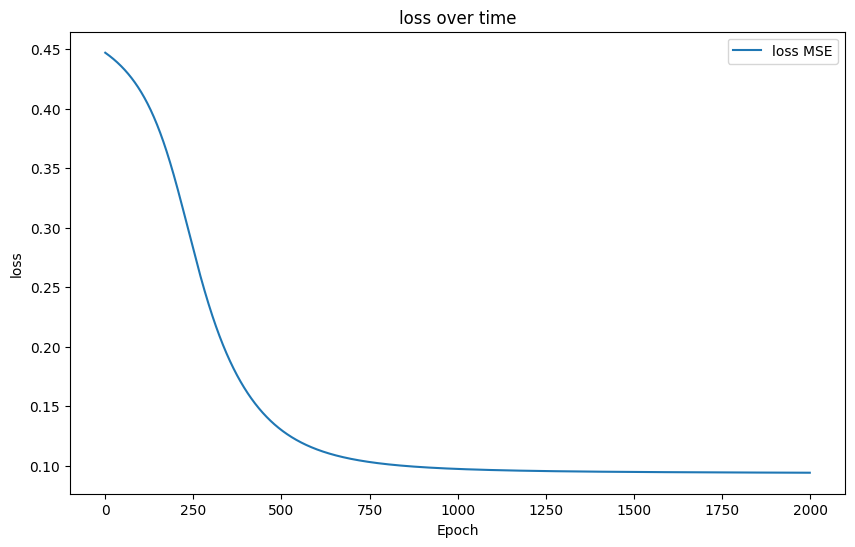

In [8]:
# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(log_loss, label='loss MSE')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('loss over time')
plt.legend()
plt.show()